In [1]:
import numpy as np
import pandas as pd

In [2]:
import tensorflow as tf

In [3]:
import threading
import os
import cPickle as pickle
import logging
import pprint
import glob
import collections
import struct
import json
logging.basicConfig(format='%(asctime)s %(levelname)s: %(message)s', datefmt='%m/%d/%Y %I:%M:%S %p', level=logging.INFO)


In [4]:
logging.info('abc')

07/29/2017 03:03:30 PM INFO: abc


In [5]:
class GeneratorRunner(object):
    "Custom runner that that runs an generator in a thread and enqueues the outputs."

    def __init__(self, generator, placeholders, enqueue_op, close_op):
        self._generator = generator
        self._placeholders = placeholders
        self._enqueue_op = enqueue_op
        self._close_op = close_op

    def _run(self, sess, coord):
        try:
            while not coord.should_stop():
                try:
                    values = next(self._generator)

                    assert len(values) == len(self._placeholders), \
                        'generator values and placeholders must have the same length'

                    feed_dict = {placeholder: value \
                        for placeholder, value in zip(self._placeholders, values)}
                    sess.run(self._enqueue_op, feed_dict=feed_dict)
                except (StopIteration, tf.errors.OutOfRangeError, tf.errors.DeadlineExceededError, tf.errors.CancelledError) as e:
                    logging.warning ("%s %s %s", self.__class__.__name__, "exception:", str(type(e)))
                    try:
                        sess.run(self._close_op)
                    except Exception:
                        pass
                    return
        except Exception as ex:
            if coord:
                logging.info ("%s %s %s %s", self.__class__.__name__, "request stop from", self._run.__name__, str(ex))
                coord.request_stop(ex)
                pass
            else: 
                raise

    def create_threads(self, sess, coord=None, daemon=False, start=False):
        "Called by `start_queue_runners`."

        thread = threading.Thread(
            target=self._run,
            args=(sess, coord))

        if coord:
            coord.register_thread(thread)

        if daemon:
            thread.daemon = True

        if start:
            thread.start()

        return [thread]

def read_batch_generator(
        generator, dtypes, shapes, batch_size,
        queue_capacity=10000,
        allow_smaller_final_batch=False):
    "Reads values from an generator, queues, and batches."

    assert len(dtypes) == len(shapes), 'dtypes and shapes must have the same length'
    logging.info('shapes: %s, types: %s, batchsize: %d', str(shapes), str(dtypes), batch_size)
    queue = tf.FIFOQueue(
        capacity=queue_capacity,
        dtypes=dtypes,
        shapes=shapes)

    placeholders = [tf.placeholder(dtype, shape) for dtype, shape in zip(dtypes, shapes)]

    enqueue_op = queue.enqueue(placeholders)
    close_op = queue.close(cancel_pending_enqueues=True)
    global_close_ops.append(close_op)
    queue_runner = GeneratorRunner(generator, placeholders, enqueue_op, close_op)
    tf.train.add_queue_runner(queue_runner)

    if allow_smaller_final_batch:
        return queue.dequeue_up_to(batch_size)
    else:
        return queue.dequeue_many(batch_size)    

In [6]:

import Queue
class MemoryGenerator(object):
    def __init__(self, daily_data,attrib_data, epochs=np.inf):
        self.daily_data = daily_data
        self.attrib_data = attrib_data        
        self.shuffle=True
        self.epochs = epochs
        self.N = len(self.daily_data)*10
        self.curr_epoch = 1
        self.curr_i = 0
        self.q = Queue.Queue()
        if self.shuffle:
            self.do_shuffle()
    def __iter__(self):
        return self
    def do_shuffle(self):
        idx = np.random.permutation(range(len(self.daily_data)))
        self.daily_data = self.daily_data[idx]     
        self.attrib_data = self.attrib_data[idx]
    def fill_queue(self):
        for _ in range(100):
            i=int(np.random.random()*len(self.daily_data))
            attrib_row=self.attrib_data[i]
            row=self.daily_data[i]
            len1=128
            len2=60
            j=int(np.random.random()*(len(row)-1))
            part_x=row[:j]
            if len(part_x)>=len1:
                x=part_x[len(part_x)-len1:]
            else:
                x=np.zeros(len1,dtype=np.float32)
                x[len1-len(part_x):]=part_x
            part_y=row[j:j+len2]
            y=np.zeros(len2,dtype=np.float32)
            y[:len(part_y)]=part_y
            mask=np.zeros(len2,dtype=np.float32)
            mask[:len(part_y)]=1
            self.q.put((x.astype(np.float32),attrib_row.astype(np.float32),np.array(y,dtype=np.float32),mask))
    def __next__(self):
        return self.next()
    def next(self):
        if self.curr_i >= self.N:
            self.curr_i = 0
            self.curr_epoch += 1
            if self.curr_epoch > self.epochs: raise StopIteration
            if self.shuffle: 
                self.do_shuffle()
        if self.q.empty(): self.fill_queue()
        X1,X2, y,mask = self.q.get()
        self.curr_i += 1
        return X1,X2, y,mask 


In [7]:
def make_train_readers(daily_data,attrib_data, nrows=None, batchsize=60):
    print daily_data.shape, attrib_data.shape
    train_generator = MemoryGenerator(daily_data,attrib_data)
    return read_batch_generator(train_generator, [tf.float32, tf.float32, tf.float32, tf.float32], 
                                [(128,), (12,), (60,),(60,)], batchsize, allow_smaller_final_batch=True),train_generator

In [8]:
locales=sorted([u'en', u'ja', u'de', u'fr', u'zh', u'ru', u'es'])
locale_map={v:u for u,v in enumerate(locales)}
locale_map

{u'de': 0, u'en': 1, u'es': 2, u'fr': 3, u'ja': 4, u'ru': 5, u'zh': 6}

In [9]:
access_map={u'all-access':0, u'mobile-web':1, u'desktop':2}
agent_map={u'all-agents':0, u'spider':1}
access_map,agent_map

({u'all-access': 0, u'desktop': 2, u'mobile-web': 1},
 {u'all-agents': 0, u'spider': 1})

In [10]:
def f_map(series, data_map):
    lst=[]
    keys=list(data_map.keys())
    for k in keys:
        lst.append(series.map(lambda u: (u==k)*1))
    df=pd.concat(lst,axis=1)
    df.columns=[series.name+"_"+u for u in keys]
    return df

In [11]:
def make_data():
    import pandas as pd
    csv_path="../input/newtrain_1.csv"
    data = pd.read_csv(csv_path, nrows=None)
    datecols=[u for u in data.columns if u.startswith("20")]
    daily_data=data[datecols].values.astype(np.float32)
    attrib_data=pd.concat([f_map(data.locale,locale_map),
                           f_map(data.agent,agent_map),
                           f_map(data.access,access_map)],axis=1).values.astype(np.float32)    
    print daily_data.shape,attrib_data.shape
    return daily_data,attrib_data

In [12]:
daily_data,attrib_data=make_data()

(145063, 550) (145063, 12)


In [13]:
print np.mean(daily_data==0)
daily_data += (daily_data==0)*0.1
print np.mean(daily_data==0)

0.0909115851232
0.0


In [14]:
if 0:
    global_close_ops = []
    #daily_data,attrib_data=make_data()
    _, generator=make_train_readers(daily_data,attrib_data)
    a,b,c,d= generator.next()
    print a,b,c,d    
    print a.shape,b.shape,c.shape,d.shape


In [15]:
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>" % size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    from IPython.display import clear_output, Image, display, HTML

    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph' + str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))


In [16]:
def weight_variable(shape, name):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name=name)

def bias_variable(shape, name):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name=name)

def dense(x, size, scope, with_activation=True):
    if 1:
        with tf.variable_scope(scope):
            w = weight_variable(shape=[int(x.get_shape()[-1]), size], name=None)
            b = bias_variable(shape=[size], name=None)
            h1 = tf.matmul(x, w) + b
            layer=tf.sigmoid(h1) if with_activation else h1
            print layer.get_shape()
    return layer,w,b
from tensorflow.contrib import rnn
def lstm(x,x2, n_hiddens, n_input, n_output, scope):
    if 1:
        with tf.variable_scope(scope):
            x = tf.reshape(x, [-1, n_input])
            x = tf.split(x,n_input,1)
            basic_rnn_cells = [rnn.BasicLSTMCell(n_hidden) for n_hidden in n_hiddens]
            rnn_cell = rnn.MultiRNNCell(basic_rnn_cells)
            outputs, states = rnn.static_rnn(rnn_cell, x, dtype=tf.float32) 
            concat_x=tf.concat([outputs[-1],x2],-1)
            print outputs[-1].get_shape(), concat_x.get_shape()             
            return concat_x

def get_Xy(x_size,x2_size,y_size):
    X = tf.placeholder("float", shape=[None, x_size], name='input_x')
    X2 = tf.placeholder("float", shape=[None, x2_size], name='input_x2')    
    l2_scale = tf.placeholder(tf.float32, name='l2_scale')
    y = tf.placeholder("float", shape=[None, y_size], name='input_y')
    mask = tf.placeholder("float", shape=[None, y_size], name='mask')
    return X,X2, y,mask, l2_scale

In [17]:
class MyModel(object):
    def __init__(self, x_size,y_size, n_hiddens,l2_scale,phase=True ):
        self.phase=phase
        n_hiddens=n_hiddens
        self.graph = tf.Graph()
        self.all_denses = []
        with self.graph.as_default(): 
            self.X, self.X2, self.y, self.mask, self.l2_scale = get_Xy(x_size,12, y_size)
            assert(x_size == self.X.get_shape()[1])
            with tf.variable_scope("nodes"):
                self.X, self.y, self.loss, self.smape \
                     = self.make_model(x_size=x_size, y_size=y_size, n_hiddens=n_hiddens)

            
            with tf.variable_scope('saver'):
                    self.saver = tf.train.Saver()

            update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
            with tf.variable_scope('optimizer'):
                with tf.control_dependencies(update_ops):
                    self.optimizer = tf.train.AdamOptimizer().minimize(self.loss)
        self._session = None    
    @property
    def session(self): 
        if self._session is None:
            self._session = tf.Session(graph=self.graph)
        return self._session
    
    def close_session(self):
        if self._session is not None:
            self._session.close()
            self._session = None
    def initialize(self, session=None):
        with self.graph.as_default():
            init_op = tf.global_variables_initializer()        
        self.session.run(init_op) 
        return self.session
 
        
    def make_model(self, x_size,y_size, n_hiddens):
        X_raw, y  = self.X, self.y 
        logging.debug ("%s %s", self.__class__.__name__,
                       'input shapes: X={},y={}'.format(X_raw.get_shape(), None if y is None else y.get_shape()))

        h = tf.log(X_raw+1)
        #h=     tf.layers.batch_normalization(h,center=False, scale=True,training=self.phase)
        
        h=lstm(h,self.X2, [n_hiddens[0]], x_size, y_size, 'lstm')
        for i in range(0, len(n_hiddens)):
            n_hidden = n_hiddens[i]
            h, w,b = dense(h, n_hidden,'dense')
            self.all_denses.append((h,w,b))

        logits_sum,_,_=dense(h,y_size,'dense',with_activation=False)
        
        with tf.variable_scope("loss"):
            epsilon = 1e-7        
            l2_loss = 0
            if 1:  # self.l2_scale > 0:
                logging.info('use l2 reg scale %s', str(self.l2_scale))
                for _,w,_ in self.all_denses:
                    l2_loss = l2_loss + tf.reduce_sum(w ** 2)
                l2_loss = l2_loss * self.l2_scale
                self.l2_loss = l2_loss
            if 1:
                predictions = tf.identity(logits_sum, name='prediction')
                float_labels = tf.cast(y, tf.float32)
                error=predictions-float_labels                
                this_loss =  tf.abs(predictions-float_labels)/(tf.abs(predictions)+tf.abs(float_labels))
                this_loss=this_loss*self.mask
                this_loss = tf.identity(2* tf.reduce_sum(this_loss)/tf.reduce_sum(self.mask), name='smape')                          
                loss = this_loss + l2_loss

            logging.info ('%s %s %s', self.__class__.__name__, 'logits shape', logits_sum.get_shape())

        return X_raw, y, loss, this_loss
 
    
    def save(self, prefix, ckpt=1):
        checkpoint_name = '{}/model_{}'.format(prefix, 0)
        self.saver.save(self.session, checkpoint_name, global_step=ckpt)

    def load(self, prefix, ckpt=1):
        self.saver.restore(self.session, '{}/model_{}-{}'.format(prefix, self.model_id, ckpt))


In [18]:
if 0:
    tf.reset_default_graph()
    model = MyModel(x_size=5, y_size=2, n_hiddens=[2,2], l2_scale=0.1)
    model.initialize()
    #print [n.op for n in model.graph.as_graph_def().node];
    show_graph(model.graph.as_graph_def())

In [19]:
def svd_orthonormal(shape):
    print(shape)
    if len(shape) < 2:
        raise RuntimeError("Only shapes of length 2 or more are supported.")
    flat_shape = (shape[0], np.prod(shape[1:]))
    a = np.random.standard_normal(flat_shape)
    u, _, v = np.linalg.svd(a, full_matrices=False)
    q = u if u.shape == flat_shape else v
    q = q.reshape(shape)
    return q

def get_activations(model, h, X_batch):
    activations = model.session.run(h, feed_dict={model.X:X_batch})
    return activations

def LSUVinit(model, batch):
    # only these layer classes considered for LSUV initialization; add more if needed    
    margin = 0.1
    max_iter = 10
    layers_inintialized = 0
    for h,w,_ in model.all_denses:
        # avoid small layers where activation variance close to zero, esp. for small batches
        if np.prod(h.get_shape()) < 32:
            print(h, 'too small')
            continue
        logging.info('LSUV initializing' + str(h))
        layers_inintialized += 1
        needed_variance = 1.0
        
        # print ('pre',np.sum(model.session.run(np.abs(w))))
        weights = svd_orthonormal(w.get_shape())
        model.session.run(tf.assign(w, weights))
        # print (model.session.run(w),weights)
        # print ('post',np.sum(model.session.run(np.abs(w))),np.sum(np.abs(weights)))        
        acts1 = get_activations(model, h, batch)
        # print (acts1,needed_variance)
        
        var1 = np.var(acts1)
        iter1 = 0
        logging.info('var1 %f', var1)
        while (abs(needed_variance - var1) > margin):
            if np.abs(np.sqrt(var1)) < 1e-7: break  # avoid zero division
            weights /= np.sqrt(var1) / np.sqrt(needed_variance)
            model.session.run(tf.assign(w, weights))
            acts1 = get_activations(model, h, batch)
            var1 = np.var(acts1)
            iter1 += 1
            # print (acts1)
            logging.info('var1 %f', var1)
            if iter1 > max_iter:
                break
    logging.info('LSUV: total layers initialized %d', layers_inintialized)   
    return model


In [20]:

class BN(object):
    def __init__(self, x_size, y_size, n_hiddens, l2_scale=0.0, prefix='./tmp'):
        self.x_size = x_size
        self.y_size=y_size
        self.n_hiddens = n_hiddens
        self.l2_scale = l2_scale
        self.prefix = prefix
    

    def train_one_epoch(self, n_epoch, sess, model, reader, coord):
        count = 0
        loss = []; l2_loss = []
        while not coord.should_stop():
            try:
                if  True:
                    X,X2, y,mask = sess.run(reader)
                    feed_dict = {model.X:X, model.X2:X2, model.y:y, model.mask:mask, model.l2_scale: self.l2_scale}
                    _, a, aa = model.session.run([model.optimizer, model.loss, model.l2_loss], 
                                                    feed_dict=feed_dict)
                    loss.append(a)
                    l2_loss.append(aa)
                    count += len(y)
                    if count % self.net_train_report_intev == 0:

                        logging.info ('[epoch {}][step {}] AVG LOSS: {}, L2LOSS: {}'.format(
                            n_epoch, count, np.mean(loss), np.mean(l2_loss)))
                        loss = []; l2_loss = []
                        #self.read_params()

                    if count >= self.net_train_eval_intev:
                        return 0
            except tf.errors.OutOfRangeError:
                logging.info (self.__class__.__name__, 'Done with read')
                logging.info (self.__class__.__name__, "request stop from", self.train_one_epoch.__name__)                
                coord.request_stop()
                for o in global_close_ops: sess.run(o)
                return 1                                      
            except:
                raise           
        return 0


    def save_net(self, sess, model, n_epoch):
        model.save(prefix=self.prefix, ckpt=n_epoch)

    def train(self, daily_data,attrib_data, net_round,net_train_report_intev,net_train_eval_intev):
        self.net_train_report_intev=net_train_report_intev
        self.net_train_eval_intev=net_train_eval_intev
        model = MyModel(x_size=self.x_size, y_size=self.y_size, n_hiddens=self.n_hiddens,
                             l2_scale=self.l2_scale)
        model.initialize()
        config = tf.ConfigProto(log_device_placement=True)
        # config.gpu_options.per_process_gpu_memory_fraction = 0.3  # don't hog all vRAM
        # config.operation_timeout_in_ms = 10000  # terminate on long hangs
        with tf.Session(config=config) as sess:
            train_reader,_ = make_train_readers(daily_data,attrib_data,batchsize=batch_size,nrows=None)            
            coord = tf.train.Coordinator()
            threads = tf.train.start_queue_runners(sess=sess, coord=coord)
            res = None
            try:
                if 0:
                    logging.info('Use LSUV initialization')
                    batch = np.concatenate([sess.run(train_reader)[0] for _ in range(100)])
                    LSUVinit(model, batch)
                for j in range(net_round):
                    logging.info ('[epoch {}] start net training'.format(j))
                    if self.train_one_epoch(j, sess, model, train_reader, coord) is None:
                        raise Exception("train error")
                    self.save_net(sess=sess, model=model, n_epoch=0)
            except:
                raise 
            finally:
                logging.info ('%s %s %s', self.__class__.__name__, "request stop from", self.train.__name__)
                for o in global_close_ops: sess.run(o)                
                coord.request_stop()

            coord.join(threads)
            sess.close()
            model.close_session()
            return 

    def read_params(self):
	try:
	    with open('param.txt') as f:
	        m = json.load(f)
 	    a = m["l2_scale"]
	    if self.l2_scale != a: 
		logging.info("Change l2_scale from %e to %e", self.l2_scale, a)
	     	self.l2_scale = a
	except:
	    logging.error('read params failed')


In [21]:
daily_data.shape

(145063, 550)

In [22]:
l2_scale = 1e-8*0

batch_size = 256

if 0: #test
    n_hiddens=[10]
    net_round=10
    net_train_report_intev=batch_size*10
    net_train_eval_intev=10000
else:
    n_hiddens=[512,512]    
    net_round=200
    net_train_report_intev=batch_size*100
    net_train_eval_intev=batch_size*1000

In [23]:
global_close_ops = []
tf.reset_default_graph()       
model = BN(x_size=128, y_size=60, n_hiddens=n_hiddens, prefix='tmp_pred60_lstm', l2_scale=l2_scale)
model.train(daily_data,attrib_data,  \
           net_round=net_round,  net_train_report_intev=net_train_report_intev,
            net_train_eval_intev=net_train_eval_intev )  

07/29/2017 03:05:39 PM INFO: use l2 reg scale Tensor("l2_scale:0", dtype=float32)
07/29/2017 03:05:39 PM INFO: MyModel logits shape (?, 60)


(?, 512) (?, 524)
(?, 512)
(?, 512)
(?, 60)
(145063, 550) (145063, 12)


07/29/2017 03:05:52 PM INFO: shapes: [(128,), (12,), (60,), (60,)], types: [tf.float32, tf.float32, tf.float32, tf.float32], batchsize: 256
07/29/2017 03:05:52 PM INFO: [epoch 0] start net training
07/29/2017 03:06:05 PM INFO: [epoch 0][step 25600] AVG LOSS: 1.71875059605, L2LOSS: 0.0
07/29/2017 03:06:18 PM INFO: [epoch 0][step 51200] AVG LOSS: 1.66015183926, L2LOSS: 0.0
07/29/2017 03:06:31 PM INFO: [epoch 0][step 76800] AVG LOSS: 1.6438087225, L2LOSS: 0.0
07/29/2017 03:06:44 PM INFO: [epoch 0][step 102400] AVG LOSS: 1.62447309494, L2LOSS: 0.0
07/29/2017 03:06:57 PM INFO: [epoch 0][step 128000] AVG LOSS: 1.61830854416, L2LOSS: 0.0
07/29/2017 03:07:10 PM INFO: [epoch 0][step 153600] AVG LOSS: 1.55216181278, L2LOSS: 0.0
07/29/2017 03:07:23 PM INFO: [epoch 0][step 179200] AVG LOSS: 1.45292568207, L2LOSS: 0.0
07/29/2017 03:07:37 PM INFO: [epoch 0][step 204800] AVG LOSS: 1.26764953136, L2LOSS: 0.0
07/29/2017 03:07:50 PM INFO: [epoch 0][step 230400] AVG LOSS: 1.15075910091, L2LOSS: 0.0
07/29

07/29/2017 03:24:47 PM INFO: [epoch 8][step 153600] AVG LOSS: 0.596694052219, L2LOSS: 0.0
07/29/2017 03:25:00 PM INFO: [epoch 8][step 179200] AVG LOSS: 0.586883187294, L2LOSS: 0.0
07/29/2017 03:25:13 PM INFO: [epoch 8][step 204800] AVG LOSS: 0.591443240643, L2LOSS: 0.0
07/29/2017 03:25:26 PM INFO: [epoch 8][step 230400] AVG LOSS: 0.588490128517, L2LOSS: 0.0
07/29/2017 03:25:40 PM INFO: [epoch 8][step 256000] AVG LOSS: 0.585385978222, L2LOSS: 0.0
07/29/2017 03:25:41 PM INFO: [epoch 9] start net training
07/29/2017 03:25:54 PM INFO: [epoch 9][step 25600] AVG LOSS: 0.588900208473, L2LOSS: 0.0
07/29/2017 03:26:07 PM INFO: [epoch 9][step 51200] AVG LOSS: 0.591180026531, L2LOSS: 0.0
07/29/2017 03:26:20 PM INFO: [epoch 9][step 76800] AVG LOSS: 0.588406920433, L2LOSS: 0.0
07/29/2017 03:26:34 PM INFO: [epoch 9][step 102400] AVG LOSS: 0.586188197136, L2LOSS: 0.0
07/29/2017 03:26:46 PM INFO: [epoch 9][step 128000] AVG LOSS: 0.586255431175, L2LOSS: 0.0
07/29/2017 03:26:59 PM INFO: [epoch 9][step 1

07/29/2017 03:43:27 PM INFO: [epoch 17][step 25600] AVG LOSS: 0.448870480061, L2LOSS: 0.0
07/29/2017 03:43:40 PM INFO: [epoch 17][step 51200] AVG LOSS: 0.44399189949, L2LOSS: 0.0
07/29/2017 03:43:53 PM INFO: [epoch 17][step 76800] AVG LOSS: 0.44112816453, L2LOSS: 0.0
07/29/2017 03:44:06 PM INFO: [epoch 17][step 102400] AVG LOSS: 0.445116639137, L2LOSS: 0.0
07/29/2017 03:44:19 PM INFO: [epoch 17][step 128000] AVG LOSS: 0.443059414625, L2LOSS: 0.0
07/29/2017 03:44:32 PM INFO: [epoch 17][step 153600] AVG LOSS: 0.444970846176, L2LOSS: 0.0
07/29/2017 03:44:45 PM INFO: [epoch 17][step 179200] AVG LOSS: 0.438758075237, L2LOSS: 0.0
07/29/2017 03:44:58 PM INFO: [epoch 17][step 204800] AVG LOSS: 0.433313727379, L2LOSS: 0.0
07/29/2017 03:45:11 PM INFO: [epoch 17][step 230400] AVG LOSS: 0.437462240458, L2LOSS: 0.0
07/29/2017 03:45:24 PM INFO: [epoch 17][step 256000] AVG LOSS: 0.43829280138, L2LOSS: 0.0
07/29/2017 03:45:26 PM INFO: [epoch 18] start net training
07/29/2017 03:45:38 PM INFO: [epoch 1

07/29/2017 04:02:15 PM INFO: [epoch 25][step 179200] AVG LOSS: 0.426132291555, L2LOSS: 0.0
07/29/2017 04:02:28 PM INFO: [epoch 25][step 204800] AVG LOSS: 0.424703687429, L2LOSS: 0.0
07/29/2017 04:02:41 PM INFO: [epoch 25][step 230400] AVG LOSS: 0.427161097527, L2LOSS: 0.0
07/29/2017 04:02:54 PM INFO: [epoch 25][step 256000] AVG LOSS: 0.426430612803, L2LOSS: 0.0
07/29/2017 04:02:55 PM INFO: [epoch 26] start net training
07/29/2017 04:03:08 PM INFO: [epoch 26][step 25600] AVG LOSS: 0.427417248487, L2LOSS: 0.0
07/29/2017 04:03:21 PM INFO: [epoch 26][step 51200] AVG LOSS: 0.422724604607, L2LOSS: 0.0
07/29/2017 04:03:34 PM INFO: [epoch 26][step 76800] AVG LOSS: 0.42444935441, L2LOSS: 0.0
07/29/2017 04:03:46 PM INFO: [epoch 26][step 102400] AVG LOSS: 0.423811793327, L2LOSS: 0.0
07/29/2017 04:03:59 PM INFO: [epoch 26][step 128000] AVG LOSS: 0.424252152443, L2LOSS: 0.0
07/29/2017 04:04:12 PM INFO: [epoch 26][step 153600] AVG LOSS: 0.424449384212, L2LOSS: 0.0
07/29/2017 04:04:24 PM INFO: [epoch

07/29/2017 04:20:22 PM INFO: [epoch 34][step 51200] AVG LOSS: 0.409848630428, L2LOSS: 0.0
07/29/2017 04:20:34 PM INFO: [epoch 34][step 76800] AVG LOSS: 0.411776781082, L2LOSS: 0.0
07/29/2017 04:20:47 PM INFO: [epoch 34][step 102400] AVG LOSS: 0.405225992203, L2LOSS: 0.0
07/29/2017 04:20:59 PM INFO: [epoch 34][step 128000] AVG LOSS: 0.410563379526, L2LOSS: 0.0
07/29/2017 04:21:11 PM INFO: [epoch 34][step 153600] AVG LOSS: 0.411720097065, L2LOSS: 0.0
07/29/2017 04:21:24 PM INFO: [epoch 34][step 179200] AVG LOSS: 0.411125987768, L2LOSS: 0.0
07/29/2017 04:21:36 PM INFO: [epoch 34][step 204800] AVG LOSS: 0.407410889864, L2LOSS: 0.0
07/29/2017 04:21:48 PM INFO: [epoch 34][step 230400] AVG LOSS: 0.408329576254, L2LOSS: 0.0
07/29/2017 04:22:01 PM INFO: [epoch 34][step 256000] AVG LOSS: 0.407009512186, L2LOSS: 0.0
07/29/2017 04:22:02 PM INFO: [epoch 35] start net training
07/29/2017 04:22:14 PM INFO: [epoch 35][step 25600] AVG LOSS: 0.406780481339, L2LOSS: 0.0
07/29/2017 04:22:27 PM INFO: [epoc

07/29/2017 04:38:29 PM INFO: [epoch 42][step 204800] AVG LOSS: 0.402190446854, L2LOSS: 0.0
07/29/2017 04:38:41 PM INFO: [epoch 42][step 230400] AVG LOSS: 0.406832575798, L2LOSS: 0.0
07/29/2017 04:38:53 PM INFO: [epoch 42][step 256000] AVG LOSS: 0.404522776604, L2LOSS: 0.0
07/29/2017 04:38:55 PM INFO: [epoch 43] start net training
07/29/2017 04:39:08 PM INFO: [epoch 43][step 25600] AVG LOSS: 0.405779480934, L2LOSS: 0.0
07/29/2017 04:39:20 PM INFO: [epoch 43][step 51200] AVG LOSS: 0.401688873768, L2LOSS: 0.0
07/29/2017 04:39:32 PM INFO: [epoch 43][step 76800] AVG LOSS: 0.404132753611, L2LOSS: 0.0
07/29/2017 04:39:45 PM INFO: [epoch 43][step 102400] AVG LOSS: 0.404411613941, L2LOSS: 0.0
07/29/2017 04:39:57 PM INFO: [epoch 43][step 128000] AVG LOSS: 0.406376451254, L2LOSS: 0.0
07/29/2017 04:40:09 PM INFO: [epoch 43][step 153600] AVG LOSS: 0.404056549072, L2LOSS: 0.0
07/29/2017 04:40:22 PM INFO: [epoch 43][step 179200] AVG LOSS: 0.404760628939, L2LOSS: 0.0
07/29/2017 04:40:34 PM INFO: [epoc

07/29/2017 04:56:25 PM INFO: [epoch 51][step 76800] AVG LOSS: 0.403260350227, L2LOSS: 0.0
07/29/2017 04:56:38 PM INFO: [epoch 51][step 102400] AVG LOSS: 0.402123004198, L2LOSS: 0.0
07/29/2017 04:56:50 PM INFO: [epoch 51][step 128000] AVG LOSS: 0.400926887989, L2LOSS: 0.0
07/29/2017 04:57:03 PM INFO: [epoch 51][step 153600] AVG LOSS: 0.398108452559, L2LOSS: 0.0
07/29/2017 04:57:15 PM INFO: [epoch 51][step 179200] AVG LOSS: 0.404100954533, L2LOSS: 0.0
07/29/2017 04:57:28 PM INFO: [epoch 51][step 204800] AVG LOSS: 0.404179036617, L2LOSS: 0.0
07/29/2017 04:57:41 PM INFO: [epoch 51][step 230400] AVG LOSS: 0.398792147636, L2LOSS: 0.0
07/29/2017 04:57:53 PM INFO: [epoch 51][step 256000] AVG LOSS: 0.3999581635, L2LOSS: 0.0
07/29/2017 04:57:54 PM INFO: [epoch 52] start net training
07/29/2017 04:58:07 PM INFO: [epoch 52][step 25600] AVG LOSS: 0.403495401144, L2LOSS: 0.0
07/29/2017 04:58:19 PM INFO: [epoch 52][step 51200] AVG LOSS: 0.400457262993, L2LOSS: 0.0
07/29/2017 04:58:32 PM INFO: [epoch 

07/29/2017 05:14:33 PM INFO: [epoch 59][step 230400] AVG LOSS: 0.399138897657, L2LOSS: 0.0
07/29/2017 05:14:45 PM INFO: [epoch 59][step 256000] AVG LOSS: 0.396799862385, L2LOSS: 0.0
07/29/2017 05:14:46 PM INFO: [epoch 60] start net training
07/29/2017 05:14:59 PM INFO: [epoch 60][step 25600] AVG LOSS: 0.401742964983, L2LOSS: 0.0
07/29/2017 05:15:11 PM INFO: [epoch 60][step 51200] AVG LOSS: 0.400279730558, L2LOSS: 0.0
07/29/2017 05:15:24 PM INFO: [epoch 60][step 76800] AVG LOSS: 0.39759349823, L2LOSS: 0.0
07/29/2017 05:15:36 PM INFO: [epoch 60][step 102400] AVG LOSS: 0.401865720749, L2LOSS: 0.0
07/29/2017 05:15:49 PM INFO: [epoch 60][step 128000] AVG LOSS: 0.396754622459, L2LOSS: 0.0
07/29/2017 05:16:01 PM INFO: [epoch 60][step 153600] AVG LOSS: 0.397247880697, L2LOSS: 0.0
07/29/2017 05:16:14 PM INFO: [epoch 60][step 179200] AVG LOSS: 0.398671448231, L2LOSS: 0.0
07/29/2017 05:16:27 PM INFO: [epoch 60][step 204800] AVG LOSS: 0.398874938488, L2LOSS: 0.0
07/29/2017 05:16:39 PM INFO: [epoch

07/29/2017 05:32:28 PM INFO: [epoch 68][step 102400] AVG LOSS: 0.394085198641, L2LOSS: 0.0
07/29/2017 05:32:41 PM INFO: [epoch 68][step 128000] AVG LOSS: 0.39644870162, L2LOSS: 0.0
07/29/2017 05:32:53 PM INFO: [epoch 68][step 153600] AVG LOSS: 0.394113391638, L2LOSS: 0.0
07/29/2017 05:33:05 PM INFO: [epoch 68][step 179200] AVG LOSS: 0.392728030682, L2LOSS: 0.0
07/29/2017 05:33:18 PM INFO: [epoch 68][step 204800] AVG LOSS: 0.398918509483, L2LOSS: 0.0
07/29/2017 05:33:30 PM INFO: [epoch 68][step 230400] AVG LOSS: 0.39500144124, L2LOSS: 0.0
07/29/2017 05:33:43 PM INFO: [epoch 68][step 256000] AVG LOSS: 0.397067904472, L2LOSS: 0.0
07/29/2017 05:33:44 PM INFO: [epoch 69] start net training
07/29/2017 05:33:57 PM INFO: [epoch 69][step 25600] AVG LOSS: 0.393607407808, L2LOSS: 0.0
07/29/2017 05:34:09 PM INFO: [epoch 69][step 51200] AVG LOSS: 0.398127377033, L2LOSS: 0.0
07/29/2017 05:34:22 PM INFO: [epoch 69][step 76800] AVG LOSS: 0.398774117231, L2LOSS: 0.0
07/29/2017 05:34:34 PM INFO: [epoch 

07/29/2017 05:50:34 PM INFO: [epoch 76][step 256000] AVG LOSS: 0.394382745028, L2LOSS: 0.0
07/29/2017 05:50:35 PM INFO: [epoch 77] start net training
07/29/2017 05:50:48 PM INFO: [epoch 77][step 25600] AVG LOSS: 0.39530724287, L2LOSS: 0.0
07/29/2017 05:51:01 PM INFO: [epoch 77][step 51200] AVG LOSS: 0.39363488555, L2LOSS: 0.0
07/29/2017 05:51:13 PM INFO: [epoch 77][step 76800] AVG LOSS: 0.396275520325, L2LOSS: 0.0
07/29/2017 05:51:26 PM INFO: [epoch 77][step 102400] AVG LOSS: 0.396792858839, L2LOSS: 0.0
07/29/2017 05:51:38 PM INFO: [epoch 77][step 128000] AVG LOSS: 0.391510009766, L2LOSS: 0.0
07/29/2017 05:51:50 PM INFO: [epoch 77][step 153600] AVG LOSS: 0.395936787128, L2LOSS: 0.0
07/29/2017 05:52:03 PM INFO: [epoch 77][step 179200] AVG LOSS: 0.392688035965, L2LOSS: 0.0
07/29/2017 05:52:16 PM INFO: [epoch 77][step 204800] AVG LOSS: 0.393438786268, L2LOSS: 0.0
07/29/2017 05:52:28 PM INFO: [epoch 77][step 230400] AVG LOSS: 0.393818706274, L2LOSS: 0.0
07/29/2017 05:52:41 PM INFO: [epoch 

07/29/2017 06:08:30 PM INFO: [epoch 85][step 128000] AVG LOSS: 0.39313223958, L2LOSS: 0.0
07/29/2017 06:08:42 PM INFO: [epoch 85][step 153600] AVG LOSS: 0.39347076416, L2LOSS: 0.0
07/29/2017 06:08:55 PM INFO: [epoch 85][step 179200] AVG LOSS: 0.395789504051, L2LOSS: 0.0
07/29/2017 06:09:07 PM INFO: [epoch 85][step 204800] AVG LOSS: 0.393085598946, L2LOSS: 0.0
07/29/2017 06:09:20 PM INFO: [epoch 85][step 230400] AVG LOSS: 0.39100509882, L2LOSS: 0.0
07/29/2017 06:09:33 PM INFO: [epoch 85][step 256000] AVG LOSS: 0.393188357353, L2LOSS: 0.0
07/29/2017 06:09:34 PM INFO: [epoch 86] start net training
07/29/2017 06:09:46 PM INFO: [epoch 86][step 25600] AVG LOSS: 0.39168971777, L2LOSS: 0.0
07/29/2017 06:09:58 PM INFO: [epoch 86][step 51200] AVG LOSS: 0.391333460808, L2LOSS: 0.0
07/29/2017 06:10:11 PM INFO: [epoch 86][step 76800] AVG LOSS: 0.391420662403, L2LOSS: 0.0
07/29/2017 06:10:23 PM INFO: [epoch 86][step 102400] AVG LOSS: 0.392435461283, L2LOSS: 0.0
07/29/2017 06:10:36 PM INFO: [epoch 86

07/29/2017 06:26:23 PM INFO: [epoch 94] start net training
07/29/2017 06:26:36 PM INFO: [epoch 94][step 25600] AVG LOSS: 0.390180289745, L2LOSS: 0.0
07/29/2017 06:26:48 PM INFO: [epoch 94][step 51200] AVG LOSS: 0.391401678324, L2LOSS: 0.0
07/29/2017 06:27:01 PM INFO: [epoch 94][step 76800] AVG LOSS: 0.3907597363, L2LOSS: 0.0
07/29/2017 06:27:13 PM INFO: [epoch 94][step 102400] AVG LOSS: 0.38970375061, L2LOSS: 0.0
07/29/2017 06:27:26 PM INFO: [epoch 94][step 128000] AVG LOSS: 0.392075181007, L2LOSS: 0.0
07/29/2017 06:27:39 PM INFO: [epoch 94][step 153600] AVG LOSS: 0.389258623123, L2LOSS: 0.0
07/29/2017 06:27:51 PM INFO: [epoch 94][step 179200] AVG LOSS: 0.393044829369, L2LOSS: 0.0
07/29/2017 06:28:04 PM INFO: [epoch 94][step 204800] AVG LOSS: 0.39430847764, L2LOSS: 0.0
07/29/2017 06:28:16 PM INFO: [epoch 94][step 230400] AVG LOSS: 0.392175912857, L2LOSS: 0.0
07/29/2017 06:28:28 PM INFO: [epoch 94][step 256000] AVG LOSS: 0.39468100667, L2LOSS: 0.0
07/29/2017 06:28:30 PM INFO: [epoch 95]

07/29/2017 06:44:30 PM INFO: [epoch 102][step 153600] AVG LOSS: 0.388038039207, L2LOSS: 0.0
07/29/2017 06:44:43 PM INFO: [epoch 102][step 179200] AVG LOSS: 0.391432613134, L2LOSS: 0.0
07/29/2017 06:44:55 PM INFO: [epoch 102][step 204800] AVG LOSS: 0.389453113079, L2LOSS: 0.0
07/29/2017 06:45:07 PM INFO: [epoch 102][step 230400] AVG LOSS: 0.391412436962, L2LOSS: 0.0
07/29/2017 06:45:20 PM INFO: [epoch 102][step 256000] AVG LOSS: 0.388000071049, L2LOSS: 0.0
07/29/2017 06:45:21 PM INFO: [epoch 103] start net training
07/29/2017 06:45:34 PM INFO: [epoch 103][step 25600] AVG LOSS: 0.389022648335, L2LOSS: 0.0
07/29/2017 06:45:46 PM INFO: [epoch 103][step 51200] AVG LOSS: 0.390777468681, L2LOSS: 0.0
07/29/2017 06:45:59 PM INFO: [epoch 103][step 76800] AVG LOSS: 0.386983901262, L2LOSS: 0.0
07/29/2017 06:46:11 PM INFO: [epoch 103][step 102400] AVG LOSS: 0.389769911766, L2LOSS: 0.0
07/29/2017 06:46:24 PM INFO: [epoch 103][step 128000] AVG LOSS: 0.390576273203, L2LOSS: 0.0
07/29/2017 06:46:37 PM 

07/29/2017 07:02:14 PM INFO: [epoch 111] start net training
07/29/2017 07:02:26 PM INFO: [epoch 111][step 25600] AVG LOSS: 0.38765847683, L2LOSS: 0.0
07/29/2017 07:02:39 PM INFO: [epoch 111][step 51200] AVG LOSS: 0.390474081039, L2LOSS: 0.0
07/29/2017 07:02:51 PM INFO: [epoch 111][step 76800] AVG LOSS: 0.389883905649, L2LOSS: 0.0
07/29/2017 07:03:03 PM INFO: [epoch 111][step 102400] AVG LOSS: 0.39064770937, L2LOSS: 0.0
07/29/2017 07:03:16 PM INFO: [epoch 111][step 128000] AVG LOSS: 0.38989597559, L2LOSS: 0.0
07/29/2017 07:03:28 PM INFO: [epoch 111][step 153600] AVG LOSS: 0.391242682934, L2LOSS: 0.0
07/29/2017 07:03:41 PM INFO: [epoch 111][step 179200] AVG LOSS: 0.390782535076, L2LOSS: 0.0
07/29/2017 07:03:53 PM INFO: [epoch 111][step 204800] AVG LOSS: 0.390180885792, L2LOSS: 0.0
07/29/2017 07:04:06 PM INFO: [epoch 111][step 230400] AVG LOSS: 0.388594448566, L2LOSS: 0.0
07/29/2017 07:04:18 PM INFO: [epoch 111][step 256000] AVG LOSS: 0.385909587145, L2LOSS: 0.0
07/29/2017 07:04:20 PM INF

07/29/2017 07:20:08 PM INFO: [epoch 119][step 128000] AVG LOSS: 0.388739436865, L2LOSS: 0.0
07/29/2017 07:20:21 PM INFO: [epoch 119][step 153600] AVG LOSS: 0.391049534082, L2LOSS: 0.0
07/29/2017 07:20:33 PM INFO: [epoch 119][step 179200] AVG LOSS: 0.389956474304, L2LOSS: 0.0
07/29/2017 07:20:46 PM INFO: [epoch 119][step 204800] AVG LOSS: 0.388215303421, L2LOSS: 0.0
07/29/2017 07:20:58 PM INFO: [epoch 119][step 230400] AVG LOSS: 0.388101041317, L2LOSS: 0.0
07/29/2017 07:21:11 PM INFO: [epoch 119][step 256000] AVG LOSS: 0.389458507299, L2LOSS: 0.0
07/29/2017 07:21:12 PM INFO: [epoch 120] start net training
07/29/2017 07:21:25 PM INFO: [epoch 120][step 25600] AVG LOSS: 0.388061434031, L2LOSS: 0.0
07/29/2017 07:21:37 PM INFO: [epoch 120][step 51200] AVG LOSS: 0.389851540327, L2LOSS: 0.0
07/29/2017 07:21:49 PM INFO: [epoch 120][step 76800] AVG LOSS: 0.389655143023, L2LOSS: 0.0
07/29/2017 07:22:02 PM INFO: [epoch 120][step 102400] AVG LOSS: 0.388944238424, L2LOSS: 0.0
07/29/2017 07:22:14 PM 

07/29/2017 07:38:02 PM INFO: [epoch 127][step 256000] AVG LOSS: 0.38967242837, L2LOSS: 0.0
07/29/2017 07:38:03 PM INFO: [epoch 128] start net training
07/29/2017 07:38:15 PM INFO: [epoch 128][step 25600] AVG LOSS: 0.388259083033, L2LOSS: 0.0
07/29/2017 07:38:28 PM INFO: [epoch 128][step 51200] AVG LOSS: 0.388347625732, L2LOSS: 0.0
07/29/2017 07:38:41 PM INFO: [epoch 128][step 76800] AVG LOSS: 0.390320420265, L2LOSS: 0.0
07/29/2017 07:38:53 PM INFO: [epoch 128][step 102400] AVG LOSS: 0.385452121496, L2LOSS: 0.0
07/29/2017 07:39:06 PM INFO: [epoch 128][step 128000] AVG LOSS: 0.387617260218, L2LOSS: 0.0
07/29/2017 07:39:18 PM INFO: [epoch 128][step 153600] AVG LOSS: 0.389323800802, L2LOSS: 0.0
07/29/2017 07:39:31 PM INFO: [epoch 128][step 179200] AVG LOSS: 0.389328122139, L2LOSS: 0.0
07/29/2017 07:39:43 PM INFO: [epoch 128][step 204800] AVG LOSS: 0.387877106667, L2LOSS: 0.0
07/29/2017 07:39:56 PM INFO: [epoch 128][step 230400] AVG LOSS: 0.38656938076, L2LOSS: 0.0
07/29/2017 07:40:08 PM IN

07/29/2017 07:55:45 PM INFO: [epoch 136][step 102400] AVG LOSS: 0.384469032288, L2LOSS: 0.0
07/29/2017 07:55:58 PM INFO: [epoch 136][step 128000] AVG LOSS: 0.384781122208, L2LOSS: 0.0
07/29/2017 07:56:11 PM INFO: [epoch 136][step 153600] AVG LOSS: 0.390811681747, L2LOSS: 0.0
07/29/2017 07:56:23 PM INFO: [epoch 136][step 179200] AVG LOSS: 0.386270672083, L2LOSS: 0.0
07/29/2017 07:56:35 PM INFO: [epoch 136][step 204800] AVG LOSS: 0.386044085026, L2LOSS: 0.0
07/29/2017 07:56:48 PM INFO: [epoch 136][step 230400] AVG LOSS: 0.385648965836, L2LOSS: 0.0
07/29/2017 07:57:00 PM INFO: [epoch 136][step 256000] AVG LOSS: 0.388251125813, L2LOSS: 0.0
07/29/2017 07:57:02 PM INFO: [epoch 137] start net training
07/29/2017 07:57:14 PM INFO: [epoch 137][step 25600] AVG LOSS: 0.385675579309, L2LOSS: 0.0
07/29/2017 07:57:26 PM INFO: [epoch 137][step 51200] AVG LOSS: 0.38880854845, L2LOSS: 0.0
07/29/2017 07:57:39 PM INFO: [epoch 137][step 76800] AVG LOSS: 0.388811409473, L2LOSS: 0.0
07/29/2017 07:57:52 PM I

07/29/2017 08:13:38 PM INFO: [epoch 144][step 230400] AVG LOSS: 0.387242227793, L2LOSS: 0.0
07/29/2017 08:13:50 PM INFO: [epoch 144][step 256000] AVG LOSS: 0.389776945114, L2LOSS: 0.0
07/29/2017 08:13:52 PM INFO: [epoch 145] start net training
07/29/2017 08:14:04 PM INFO: [epoch 145][step 25600] AVG LOSS: 0.388167798519, L2LOSS: 0.0
07/29/2017 08:14:17 PM INFO: [epoch 145][step 51200] AVG LOSS: 0.386898636818, L2LOSS: 0.0
07/29/2017 08:14:29 PM INFO: [epoch 145][step 76800] AVG LOSS: 0.388936877251, L2LOSS: 0.0
07/29/2017 08:14:42 PM INFO: [epoch 145][step 102400] AVG LOSS: 0.387333035469, L2LOSS: 0.0
07/29/2017 08:14:54 PM INFO: [epoch 145][step 128000] AVG LOSS: 0.388074338436, L2LOSS: 0.0
07/29/2017 08:15:07 PM INFO: [epoch 145][step 153600] AVG LOSS: 0.387380570173, L2LOSS: 0.0
07/29/2017 08:15:19 PM INFO: [epoch 145][step 179200] AVG LOSS: 0.388960003853, L2LOSS: 0.0
07/29/2017 08:15:32 PM INFO: [epoch 145][step 204800] AVG LOSS: 0.389541476965, L2LOSS: 0.0
07/29/2017 08:15:45 PM 

07/29/2017 08:31:20 PM INFO: [epoch 153][step 76800] AVG LOSS: 0.385247468948, L2LOSS: 0.0
07/29/2017 08:31:32 PM INFO: [epoch 153][step 102400] AVG LOSS: 0.388851672411, L2LOSS: 0.0
07/29/2017 08:31:45 PM INFO: [epoch 153][step 128000] AVG LOSS: 0.386074185371, L2LOSS: 0.0
07/29/2017 08:31:57 PM INFO: [epoch 153][step 153600] AVG LOSS: 0.389750301838, L2LOSS: 0.0
07/29/2017 08:32:09 PM INFO: [epoch 153][step 179200] AVG LOSS: 0.38732162118, L2LOSS: 0.0
07/29/2017 08:32:22 PM INFO: [epoch 153][step 204800] AVG LOSS: 0.386294513941, L2LOSS: 0.0
07/29/2017 08:32:35 PM INFO: [epoch 153][step 230400] AVG LOSS: 0.389326334, L2LOSS: 0.0
07/29/2017 08:32:47 PM INFO: [epoch 153][step 256000] AVG LOSS: 0.38997104764, L2LOSS: 0.0
07/29/2017 08:32:48 PM INFO: [epoch 154] start net training
07/29/2017 08:33:01 PM INFO: [epoch 154][step 25600] AVG LOSS: 0.38634622097, L2LOSS: 0.0
07/29/2017 08:33:14 PM INFO: [epoch 154][step 51200] AVG LOSS: 0.389271140099, L2LOSS: 0.0
07/29/2017 08:33:26 PM INFO: 

07/29/2017 08:49:13 PM INFO: [epoch 161][step 204800] AVG LOSS: 0.387476354837, L2LOSS: 0.0
07/29/2017 08:49:25 PM INFO: [epoch 161][step 230400] AVG LOSS: 0.385366737843, L2LOSS: 0.0
07/29/2017 08:49:38 PM INFO: [epoch 161][step 256000] AVG LOSS: 0.387742072344, L2LOSS: 0.0
07/29/2017 08:49:39 PM INFO: [epoch 162] start net training
07/29/2017 08:49:52 PM INFO: [epoch 162][step 25600] AVG LOSS: 0.385809481144, L2LOSS: 0.0
07/29/2017 08:50:05 PM INFO: [epoch 162][step 51200] AVG LOSS: 0.386189699173, L2LOSS: 0.0
07/29/2017 08:50:17 PM INFO: [epoch 162][step 76800] AVG LOSS: 0.384794831276, L2LOSS: 0.0
07/29/2017 08:50:30 PM INFO: [epoch 162][step 102400] AVG LOSS: 0.387843579054, L2LOSS: 0.0
07/29/2017 08:50:42 PM INFO: [epoch 162][step 128000] AVG LOSS: 0.386908978224, L2LOSS: 0.0
07/29/2017 08:50:55 PM INFO: [epoch 162][step 153600] AVG LOSS: 0.382602035999, L2LOSS: 0.0
07/29/2017 08:51:07 PM INFO: [epoch 162][step 179200] AVG LOSS: 0.383740693331, L2LOSS: 0.0
07/29/2017 08:51:20 PM 

07/29/2017 09:06:57 PM INFO: [epoch 170][step 51200] AVG LOSS: 0.384907275438, L2LOSS: 0.0
07/29/2017 09:07:10 PM INFO: [epoch 170][step 76800] AVG LOSS: 0.38640910387, L2LOSS: 0.0
07/29/2017 09:07:22 PM INFO: [epoch 170][step 102400] AVG LOSS: 0.384543925524, L2LOSS: 0.0
07/29/2017 09:07:35 PM INFO: [epoch 170][step 128000] AVG LOSS: 0.385984838009, L2LOSS: 0.0
07/29/2017 09:07:47 PM INFO: [epoch 170][step 153600] AVG LOSS: 0.388949424028, L2LOSS: 0.0
07/29/2017 09:07:59 PM INFO: [epoch 170][step 179200] AVG LOSS: 0.388441234827, L2LOSS: 0.0
07/29/2017 09:08:12 PM INFO: [epoch 170][step 204800] AVG LOSS: 0.385926753283, L2LOSS: 0.0
07/29/2017 09:08:25 PM INFO: [epoch 170][step 230400] AVG LOSS: 0.387953788042, L2LOSS: 0.0
07/29/2017 09:08:37 PM INFO: [epoch 170][step 256000] AVG LOSS: 0.386718302965, L2LOSS: 0.0
07/29/2017 09:08:39 PM INFO: [epoch 171] start net training
07/29/2017 09:08:51 PM INFO: [epoch 171][step 25600] AVG LOSS: 0.388144135475, L2LOSS: 0.0
07/29/2017 09:09:03 PM I

07/29/2017 09:24:51 PM INFO: [epoch 178][step 179200] AVG LOSS: 0.386947929859, L2LOSS: 0.0
07/29/2017 09:25:03 PM INFO: [epoch 178][step 204800] AVG LOSS: 0.383800089359, L2LOSS: 0.0
07/29/2017 09:25:16 PM INFO: [epoch 178][step 230400] AVG LOSS: 0.382615804672, L2LOSS: 0.0
07/29/2017 09:25:28 PM INFO: [epoch 178][step 256000] AVG LOSS: 0.38810172677, L2LOSS: 0.0
07/29/2017 09:25:29 PM INFO: [epoch 179] start net training
07/29/2017 09:25:41 PM INFO: [epoch 179][step 25600] AVG LOSS: 0.383181542158, L2LOSS: 0.0
07/29/2017 09:25:54 PM INFO: [epoch 179][step 51200] AVG LOSS: 0.381388068199, L2LOSS: 0.0
07/29/2017 09:26:07 PM INFO: [epoch 179][step 76800] AVG LOSS: 0.384637326002, L2LOSS: 0.0
07/29/2017 09:26:19 PM INFO: [epoch 179][step 102400] AVG LOSS: 0.38360708952, L2LOSS: 0.0
07/29/2017 09:26:31 PM INFO: [epoch 179][step 128000] AVG LOSS: 0.384237706661, L2LOSS: 0.0
07/29/2017 09:26:44 PM INFO: [epoch 179][step 153600] AVG LOSS: 0.387583136559, L2LOSS: 0.0
07/29/2017 09:26:56 PM IN

07/29/2017 09:42:33 PM INFO: [epoch 187][step 25600] AVG LOSS: 0.386248201132, L2LOSS: 0.0
07/29/2017 09:42:45 PM INFO: [epoch 187][step 51200] AVG LOSS: 0.383670687675, L2LOSS: 0.0
07/29/2017 09:42:58 PM INFO: [epoch 187][step 76800] AVG LOSS: 0.385605424643, L2LOSS: 0.0
07/29/2017 09:43:10 PM INFO: [epoch 187][step 102400] AVG LOSS: 0.384019732475, L2LOSS: 0.0
07/29/2017 09:43:23 PM INFO: [epoch 187][step 128000] AVG LOSS: 0.384401082993, L2LOSS: 0.0
07/29/2017 09:43:35 PM INFO: [epoch 187][step 153600] AVG LOSS: 0.387829065323, L2LOSS: 0.0
07/29/2017 09:43:48 PM INFO: [epoch 187][step 179200] AVG LOSS: 0.383755177259, L2LOSS: 0.0
07/29/2017 09:44:00 PM INFO: [epoch 187][step 204800] AVG LOSS: 0.38263502717, L2LOSS: 0.0
07/29/2017 09:44:13 PM INFO: [epoch 187][step 230400] AVG LOSS: 0.3848490417, L2LOSS: 0.0
07/29/2017 09:44:26 PM INFO: [epoch 187][step 256000] AVG LOSS: 0.38441234827, L2LOSS: 0.0
07/29/2017 09:44:27 PM INFO: [epoch 188] start net training
07/29/2017 09:44:39 PM INFO

07/29/2017 10:00:28 PM INFO: [epoch 195][step 153600] AVG LOSS: 0.380824059248, L2LOSS: 0.0
07/29/2017 10:00:41 PM INFO: [epoch 195][step 179200] AVG LOSS: 0.383429229259, L2LOSS: 0.0
07/29/2017 10:00:53 PM INFO: [epoch 195][step 204800] AVG LOSS: 0.384668380022, L2LOSS: 0.0
07/29/2017 10:01:05 PM INFO: [epoch 195][step 230400] AVG LOSS: 0.382915347815, L2LOSS: 0.0
07/29/2017 10:01:18 PM INFO: [epoch 195][step 256000] AVG LOSS: 0.38285818696, L2LOSS: 0.0
07/29/2017 10:01:19 PM INFO: [epoch 196] start net training
07/29/2017 10:01:32 PM INFO: [epoch 196][step 25600] AVG LOSS: 0.380426108837, L2LOSS: 0.0
07/29/2017 10:01:44 PM INFO: [epoch 196][step 51200] AVG LOSS: 0.385602772236, L2LOSS: 0.0
07/29/2017 10:01:57 PM INFO: [epoch 196][step 76800] AVG LOSS: 0.382403969765, L2LOSS: 0.0
07/29/2017 10:02:09 PM INFO: [epoch 196][step 102400] AVG LOSS: 0.385185778141, L2LOSS: 0.0
07/29/2017 10:02:22 PM INFO: [epoch 196][step 128000] AVG LOSS: 0.383403331041, L2LOSS: 0.0
07/29/2017 10:02:34 PM I

# prediction

In [24]:
sess=tf.Session()

In [25]:
saver = tf.train.import_meta_graph('tmp_pred60_lstm/model_0-0.meta')

In [27]:
saver.restore(sess,tf.train.latest_checkpoint('tmp_pred60_lstm/'))

INFO:tensorflow:Restoring parameters from tmp_pred60_lstm/model_0-0


07/29/2017 10:15:44 PM INFO: Restoring parameters from tmp_pred60_lstm/model_0-0


In [28]:
graph = tf.get_default_graph()

In [46]:
x = graph.get_tensor_by_name("input_x:0")
x2 = graph.get_tensor_by_name("input_x2:0")
l2_scale = graph.get_tensor_by_name("l2_scale:0")
y = graph.get_tensor_by_name("input_y:0")
m=graph.get_tensor_by_name("mask:0")
prediction=graph.get_tensor_by_name("nodes/loss/prediction:0")
loss=graph.get_tensor_by_name('nodes/loss/smape:0')

In [43]:
X=[];X2=[];Y=[];MASK=[]
for _ in range(1000):
    i=int(np.random.random()*len(daily_data))
    attrib_row=attrib_data[i]
    row=daily_data[i]
    len1=128
    len2=60
    j=int(np.random.random()*(len(row)-len1-1))
    xx=row[j:j+len1]
    part_y=row[j+len1:j+len1+len2]
    yy=np.zeros(len2,dtype=np.float32)
    yy[:len(part_y)]=part_y
    mask=np.zeros(len2,dtype=np.float32)
    mask[:len(part_y)]=1
    a,aa,b,c= xx.astype(np.float32),attrib_row.astype(np.float32),np.array(yy,dtype=np.float32),mask
    X.append(a),X2.append(aa),Y.append(b),MASK.append(c)

In [45]:
X=np.array(X);X2=np.array(X2);Y=np.array(Y);MASK=np.array(MASK)
X.shape,X2.shape,Y.shape,MASK.shape

((1000, 128), (1000, 12), (1000, 60), (1000, 60))

In [47]:
feed_dict={x:X,x2:X2, y:Y,m:MASK,l2_scale:0}

In [48]:
sess.run(loss,feed_dict=feed_dict)

0.37176087

In [49]:
a=sess.run(prediction,feed_dict=feed_dict)
a=np.abs(a)#-1
print a.shape

(1000, 60)


In [50]:
a.max(),a.min()

(11696.18, 0.088872895)

In [51]:
this_loss =  2*np.abs(a-Y)/(np.abs(a)+np.abs(Y))
print np.sum(this_loss<=0)
this_loss=this_loss*MASK
print this_loss.sum()
this_loss.sum()/MASK.sum() 

0
20661.4


0.37176087

In [52]:
MASK.sum()

55577.0

In [61]:
lst=[]
for i in range(1000):
    u=Y[i]
    v=a[i]
    t=MASK[i]
    lst.append(((2*np.abs(u-v)/(np.abs(u)+np.abs(v)))).mean())
    #lst.append(((2*np.abs(v-u)/(np.abs(u)+np.abs(v)))*t).sum()  )  
lst=np.array(lst)
print np.sum(lst),lst.shape    

491.789 (1000,)


Populating the interactive namespace from numpy and matplotlib
0.491789


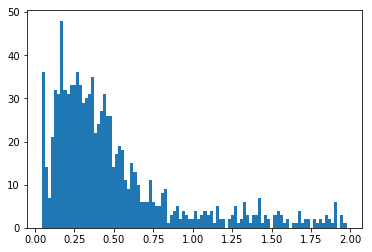

In [62]:
%pylab inline
plt.hist(lst,bins=100);
print np.mean(lst) 

1369.5 1535.96 0.112899


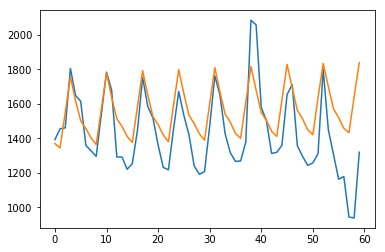

In [75]:
i=856
u=Y[i][:60]
v=a[i]
plt.plot(u)
plt.plot(v)
print np.median(u),np.median(v), (2*np.abs(u-v)/(np.abs(u)+np.abs(v))).mean()

In [76]:
daily_data.shape,attrib_data.shape

((145063, 550), (145063, 12))

In [79]:
daily_test=daily_data[:,-128:]
attrib_test=attrib_data
daily_test.shape,attrib_test.shape

((145063, 128), (145063, 12))

In [80]:
feed_dict={x:daily_test,x2:attrib_test}
predTest=sess.run(prediction,feed_dict=feed_dict)
predTest.shape

(145063, 60)

In [81]:
predTest=np.round(predTest,1)
np.mean(predTest<1)

0.031476094294662776

In [82]:
cols=pd.date_range(pd.datetime.date(datetime.datetime(2017, 1, 1)), periods=60).map(lambda u: u.strftime("%Y-%m-%d"))
idx=pd.read_csv("../input/train_1.csv",usecols=[0])["Page"]
idx.shape

(145063,)

In [83]:
submission=pd.DataFrame(predTest,columns=cols,index=idx)
submission=submission.unstack().reset_index()
submission['name']=submission.apply(lambda r: r['Page']+"_"+r['level_0'],axis=1)
submission=submission.drop(['Page','level_0'],axis=1)
submission.columns=['Visits','name']

In [84]:
submission=submission[["name",'Visits']]
submission.head()

name     Visits
0  2NE1_zh.wikipedia.org_all-access_spider_2017-0...  18.299999
1  2PM_zh.wikipedia.org_all-access_spider_2017-01-01  19.200001
2   3C_zh.wikipedia.org_all-access_spider_2017-01-01   4.700000
3  4minute_zh.wikipedia.org_all-access_spider_201...  13.400000
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...  10.600000

In [85]:
keys=pd.read_csv("../input/key_1.csv",index_col=0)

In [86]:
keys_dict=keys["Id"].to_dict()

In [87]:
submission["Id"]=submission["name"].apply(lambda u:keys_dict[u])

In [88]:
submission.isnull().sum().sum()

0L

In [89]:
submission.head()

name     Visits            Id
0  2NE1_zh.wikipedia.org_all-access_spider_2017-0...  18.299999  ff8c1aade3de
1  2PM_zh.wikipedia.org_all-access_spider_2017-01-01  19.200001  3da6fd5b23c1
2   3C_zh.wikipedia.org_all-access_spider_2017-01-01   4.700000  cd9e83803be4
3  4minute_zh.wikipedia.org_all-access_spider_201...  13.400000  65cd4af0968c
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...  10.600000  75bae1fb2637

In [90]:
submission[["Id","Visits"]].to_csv("../submission/sub_pred_lstm1_60.csv.gz",
                                   index=None, float_format='%.1f', compression="gzip")